In [1]:
import numpy as np
import matplotlib.dates as dts
import pandas as pd
import fredpy as fp
import datetime,dateutil,urllib,runProcs
import requests
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

In [2]:
# 1. Import the most recent inflation forecast data from the Philadelphia Fed, Survey of Professional Forecasters

url = "https://www.philadelphiafed.org/-/media/research-and-data/real-time-center/survey-of-professional-forecasters/historical-data/inflation.xls?la=en"
r = requests.get(url,verify=False)
with open("../xls/inflation_forecasts.xls", "wb") as code:
    code.write(r.content)

# dls = "http://www.philadelphiafed.org/research-and-data/real-time-center/survey-of-professional-forecasters/historical-data/inflation.xls"
# urllib.urlretrieve(dls, "inflation_forecasts.xls")

/Users/bcjenkin/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [3]:
# 2. Download and manage data from FRED
gdp_deflator_Q=fp.series('GDPDEF')
gdp_deflator_A=fp.series('A191RD3A086NBEA')
gdp_deflator_Q = gdp_deflator_Q.apc(method='forward')
gdp_deflator_A = gdp_deflator_A.apc(method='forward')
gdp_deflator_Q = gdp_deflator_Q.window(['07-01-1970','01-01-2200'])
gdp_deflator_A = gdp_deflator_A.window(['07-01-1970','01-01-2200'])

interest_Q = fp.series('GS1')
interest_A = fp.series('GS1')

interest_Q = interest_Q.as_frequency(freq='Q',method='mean')
interest_A = interest_A.as_frequency(freq='A',method='mean')

interest_Q = interest_Q.window(['07-01-1970','01-01-2200'])
interest_A = interest_A.window(['07-01-1970','01-01-2200'])

In [4]:
# 3. Create forecast series as FRED objects

# 3.1 import the inflation forecasts from Excel file and fill in missing value for 1974:Q3
inflation_forecasts = pd.read_excel('../xls/inflation_forecasts.xls')
inflation_forecasts['INFPGDP1YR']=inflation_forecasts['INFPGDP1YR'].interpolate()

# 3.2 initialize some FRED objects
# gdp_deflator_forecast_Q=fp.series('GDPDEF')
# gdp_deflator_forecast_A=fp.series('GDPDEF')

# 3.3 Associate forecasts with dates. The date should coincide with the start of the period for which the forecast applies.
dates = []
for i,ind in enumerate(inflation_forecasts.index):
    year =int(inflation_forecasts.iloc[i]['YEAR'])
    quart=int(inflation_forecasts.iloc[i]['QUARTER'])
    if quart == 1:
        month = '04'
    elif quart == 2:
        month = '07'
    elif quart == 3:
        month = '10'
    else:
        month = '01'
        year=year+1
    date = month+'-01-'+str(year)
    dates.append(date)
# dateNumbers = [dateutil.parser.parse(s) for s in dates]

# # 3.4 Create the FRED objects
gdp_deflator_forecast_Q = fp.to_fred_series(data = inflation_forecasts['INFPGDP1YR'].values,dates=dates,frequency_short='Q')

gdp_deflator_forecast_A = fp.to_fred_series(data = inflation_forecasts['INFPGDP1YR'].values,dates=dates,frequency_short='A')
gdp_deflator_forecast_A = gdp_deflator_forecast_A.as_frequency(freq='A',method='mean')

In [5]:
# 3.5 Create data frames with forecast inflation, actual inflation, and the 1-year bond rate
gdp_deflator_Q,gdp_deflator_forecast_Q,interest_Q = fp.window_equalize([gdp_deflator_Q,gdp_deflator_forecast_Q,interest_Q])
gdp_deflator_A,gdp_deflator_forecast_A,interest_A = fp.window_equalize([gdp_deflator_A,gdp_deflator_forecast_A,interest_A])
inflation_forecast_Q_df=pd.DataFrame({'1-year inflation forecast':gdp_deflator_forecast_Q.data,'1-year actual inflation':gdp_deflator_Q.data,'1-year nominal interest rate':interest_Q.data})
inflation_forecast_A_df=pd.DataFrame({'1-year inflation forecast':gdp_deflator_forecast_A.data,'1-year actual inflation':gdp_deflator_A.data,'1-year nominal interest rate':interest_A.data})

In [6]:
# 3.6 Save data to csv
inflation_forecast_Q_df.to_csv('../csv/inflation_forecastsQ.csv',index=True,index_label='date')
inflation_forecast_A_df.to_csv('../csv/inflation_forecastsA.csv',index=True,index_label='date')

/Users/bcjenkin/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


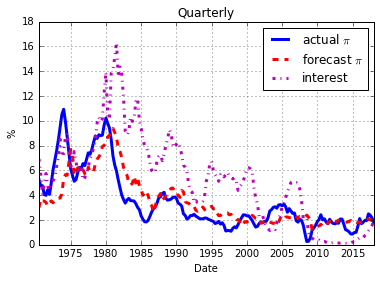

In [7]:
# 4. Plot some things

# 4.1 actual inflation, expected inflation, 1-year interest rate: quarterly
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.plot(gdp_deflator_Q.data,'b-',lw=3)
ax.plot(gdp_deflator_forecast_Q.data,'r--',lw=3)
ax.plot(interest_Q.data,'m-.',lw=3)
ax.set_title('Quarterly')
ax.set_xlabel('Date')
ax.set_ylabel('%')
ax.legend(['actual $\pi$','forecast $\pi$','interest'],loc='upper right')
# interest_Q.recessions()
plt.grid()

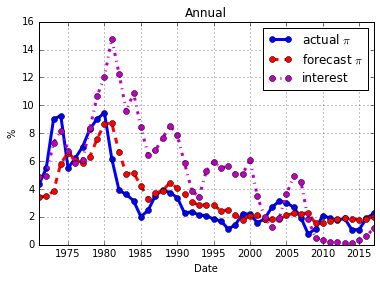

In [8]:
# 4.2 actual inflation, expected inflation, 1-year interest rate: annual
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.plot(gdp_deflator_A.data,'b-o',lw=3)
ax.plot(gdp_deflator_forecast_A.data,'r--o',lw=3)
ax.plot(interest_A.data,'m-.o',lw=3)
ax.set_title('Annual')
ax.set_xlabel('Date')
ax.set_ylabel('%')
ax.legend(['actual $\pi$','forecast $\pi$','interest'],loc='upper right')
# interest_A.recessions()
plt.grid()

In [9]:
# 5. Real interest rates

# 5.1 Construct real interest rate series: ex ante and ex post
real_ex_ante_A = interest_A.data - gdp_deflator_forecast_A.data
real_ex_post_A = interest_A.data - gdp_deflator_A.data
real_ex_ante_Q = interest_Q.data - gdp_deflator_forecast_Q.data
real_ex_post_Q = interest_Q.data - gdp_deflator_Q.data

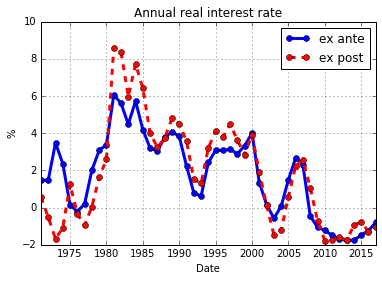

In [10]:
# 5.2 ex ante and ex post real interest rates: annual
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.plot(real_ex_ante_A,'b-o',lw=3)
ax.plot(real_ex_post_A,'r--o',lw=3)
ax.set_title('Annual real interest rate')
ax.set_xlabel('Date')
ax.set_ylabel('%')
ax.legend(['ex ante','ex post'],loc='upper right')
# interest_A.recessions()
plt.grid()

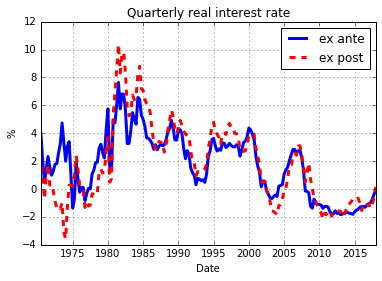

In [11]:
# 5.2 ex ante and ex post real interest rates: quarterly
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.plot(real_ex_ante_Q,'b-',lw=3)
ax.plot(real_ex_post_Q,'r--',lw=3)
ax.set_title('Quarterly real interest rate')
ax.set_xlabel('Date')
ax.set_ylabel('%')
ax.legend(['ex ante','ex post'],loc='upper right')
# interest_Q.recessions()
plt.grid()

In [12]:
# # 6. Consumption Euler equation

# 6.1 create the consumption series
cons=fp.series('PCECA')
defl=fp.series('A191RD3A086NBEA')
cons,defl = fp.window_equalize([cons,defl])

cons = cons.pc(method='backward')
interest_A,cons = fp.window_equalize([interest_A,cons])

In [13]:
# 6.2 Predicted real interest rate: sigma = 1
sigma = 1
beta = .98
gc=np.mean(cons.data)

r_pred_A = sigma*np.array(cons.data - np.mean(cons.data)) - 100*np.log(beta)
print(gc)

6.685911106098637


In [14]:
r_pred_A

array([ 3.56244456,  5.08037962,  5.93407088,  4.81980823,  6.12668483,
        6.69910087,  6.34008777,  6.97328504,  6.80686942,  5.75727595,
        5.80374072,  2.43407415,  5.489985  ,  4.57062094,  4.18106593,
        1.7279781 ,  1.91726675,  3.58240865,  2.74412271,  1.82727863,
       -1.1357057 ,  1.77821119,  1.39562047,  1.37618278,  0.45248696,
        1.01699712,  0.90569439,  1.48337377,  2.17140309,  3.02762287,
       -0.17756677, -0.7445202 ,  0.51533836,  1.67316696,  1.84206687,
        1.2017436 ,  0.15152357, -1.88501998, -6.01003255, -1.17427985,
       -0.19597289, -1.22892151, -1.84560544, -0.18731047, -0.6864732 ,
       -0.82359029, -0.32225751])

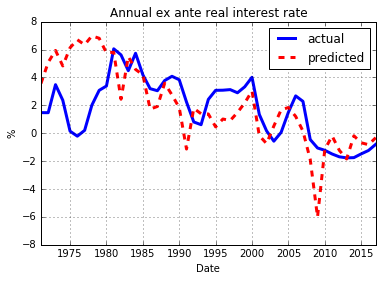

In [15]:
# 6.3 Plot the predicted real interest rate
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.plot(real_ex_ante_A,'b-',lw=3)
ax.plot(real_ex_ante_A.index,r_pred_A,'r--',lw=3)
ax.set_title('Annual ex ante real interest rate')
ax.set_xlabel('Date')
ax.set_ylabel('%')
ax.legend(['actual','predicted'],loc='upper right')
# interest_A.recessions()
plt.grid()

In [16]:
np.corrcoef(cons.data, real_ex_ante_A)

array([[1.    , 0.5281],
       [0.5281, 1.    ]])

In [17]:
# 7. Export to notebook to .py
runProcs.exportNb('inflation_forecasts')